# GI50
This NCI60 data gives an insight to effect of a chemical on cancer.
Cancer is not one disease but a collection of every possible cell in your body growing uncontrolled.
For this reason NCI60 has multiple different cell lines (column CELL_NAME).

I have here the GI50 data of the NCI60 project
GI50: concentration to stop growth with 50%. column "AVERAGE" is the average concentration needed.

In [2]:
import pandas as pd
from os.path import join as path_join
import numpy as np

In [3]:
gi50 = pd.read_csv(path_join("data", "GI50.csv"))
print(gi50.shape)
gi50.head()

(4585048, 14)


,RELEASE_DATE,EXPID,PREFIX,NSC,CONCENTRATION_UNIT,LOG_HI_CONCENTRATION,PANEL_NUMBER,CELL_NUMBER,PANEL_NAME,CELL_NAME,PANEL_CODE,COUNT,AVERAGE,STDDEV
0,20210223,0001MD02,S,123127,M,-4.6021,1,1,Non-Small Cell Lung Cancer,NCI-H23,LNS,1,-7.1391,0.0
1,20210223,0001MD02,S,123127,M,-4.6021,10,14,Melanoma,M14,MEL,1,-7.0520,0.0
2,20210223,0001MD02,S,123127,M,-4.6021,12,5,CNS Cancer,SNB-75,CNS,1,-7.1380,0.0
3,20210223,0001MD02,S,123127,M,-4.6021,4,2,Colon Cancer,HCC-2998,COL,1,-6.9426,0.0
4,20210223,0001MD02,S,123127,M,-4.6021,5,5,Breast Cancer,MDA-MB-231/ATCC,BRE,1,-6.4485,0.0


Creating a pivot table. Where every value is the average GI50 value of the combination cell line (row) and chemical (column)

In [4]:
correlation = pd.pivot_table(gi50, values='AVERAGE', index=['NSC'],
                    columns=['CELL_NAME'], aggfunc=np.mean)
correlation.head()

CELL_NAME,786-0,A-172/H.Fine,A-204,A-C/EBP 3,A-CREB 1,A-CREB 2,A-FOS 2,A-FOS 3,A-JUN 1,A-JUN 3,...,UOK-57,VDSO/CMV-8,VDSO/CMV-9,VDSO/E6-18,VDSO/E6-19,VDSO/P,WI-38,XF 498,ZR-75-1,ZR-75-30
NSC,,,,,,,,,,,,,,,,,,,,,
1,-4.716867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,-5.557233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,-5.426500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,-4.700050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.711967,NaN,NaN
112,-6.491100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The difference in how 2 cell lines react to the same chemical gives us an idea how similar those 2 cell lines are. If we take the average of all difference between all chemicals they have in common we get a difference score. Where 0 means the cells are the same, and infinite means they could not be more different.

In [6]:
np.abs(correlation["HCT-15"] - correlation["HOP-92"]).mean()

0.31367845337012784

We can do the same in a graph database. However the database is not fully in memory. So first we need to retrieve the data from the corresponding cells

In [8]:
import json

from py2neo import Graph

with open("config.json") as f:
    config = json.load(f)

neo4j_url = config.get("neo4jUrl", "bolt://localhost:7687")
user = config.get("user", "neo4j")
pswd = config.get("pswd", "password")
graph = Graph(neo4j_url, auth=(user, pswd))

At this point in the database only hold GI50 data, but we still write the query like more kinds of data exists. We look for all chemicals that have both a condition with cell A and cell B. All conditions also most have GI50 measurement.
Next up we average the measurements and calculate the distance just like above.
The values do differ a bit from each other because not all chemicals could be loaded into the database.

In [9]:
response = graph.run(
    """
    MATCH (cell1:CellLine {label: $cell_name_1})
    MATCH (gi50:Measurement {name: "GI50"})

    MATCH (chem:Synonym)<-[:USES]-(c1:Condition)-[:USES]->(cell1:CellLine)
    MATCH (c1)-[m1:MEASURES]->(gi50)
    WITH DISTINCT chem as chem, avg(toFloat(m1.value)) as values1, count(m1.value) as numVal1, gi50

    MATCH (cell2:CellLine {label: $cell_name_2})
    MATCH (chem)<-[:USES]-(c:Condition)-[:USES]->(cell2)
    MATCH (c)-[m:MEASURES]->(gi50)
    WITH DISTINCT chem as chem, avg(toFloat(m.value)) as values2, count(m.value) as numVal2, values1, numVal1

    RETURN avg(abs(values1- values2)) as distance
    """,
    cell_name_1="HCT-15",
    cell_name_2="HOP-92",
).data()
print(response[0]["distance"])

0.31269519410755936


In [16]:
for cell_line in correlation:   
    all_distance = np.abs(correlation["HCT-15"] - correlation[cell_line]).dropna()
    distance = all_distance.mean()
    print(f"Difference with {cell_line} is {distance:.4f} of {len(all_distance)} samples")

Difference with 786-0 is 0.2012 of 52098 samples
Difference with A-172/H.Fine is 0.5092 of 783 samples
Difference with A-204 is 1.4629 of 16 samples
Difference with A-C/EBP 3 is 0.8016 of 10 samples
Difference with A-CREB 1 is 0.8027 of 10 samples
Difference with A-CREB 2 is 0.6198 of 10 samples
Difference with A-FOS 2 is 0.9863 of 10 samples
Difference with A-FOS 3 is 0.8214 of 10 samples
Difference with A-JUN 1 is 0.4059 of 10 samples
Difference with A-JUN 3 is 0.3378 of 10 samples
Difference with A431 is 0.8911 of 10 samples
Difference with A498 is 0.2961 of 46660 samples
Difference with A549/ATCC is 0.2128 of 53286 samples
Difference with ACHN is 0.1831 of 52442 samples
Difference with BT-549 is 0.2632 of 37355 samples
Difference with CACO-2 is 1.0474 of 17 samples
Difference with CAKI-1 is 0.2103 of 49761 samples
Difference with CALU-1 is 0.5601 of 16 samples
Difference with CCD-19LU is 1.0922 of 3 samples
Difference with CCRF-CEM is 0.2796 of 50167 samples
Difference with CHA-59 

In [4]:
correlation.isna().sum().sum()

5819308

In [5]:
correlation.isna().sum().sum()/correlation.size

0.6456632510125747

In [6]:
correlation.isna().sum().sort_values()

CELL_NAME
A549/ATCC          1394
OVCAR-8            1519
SW-620             1522
U251               1823
SF-295             1954
                  ...  
VDSO/CMV-8        56683
VDSO/E6-18        56683
NYH/ICRF-187-1    56683
CHO               56683
NYH               56684
Length: 159, dtype: int64

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

corrMatrixCells = correlation.corr()

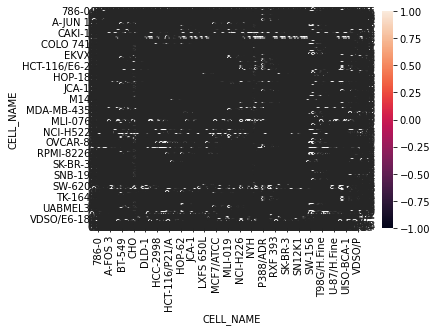

<Figure size 1152x1152 with 0 Axes>

In [8]:

sn.heatmap(corrMatrixCells, annot=True, )
plt.figure(figsize=(16, 16))
plt.show()

<AxesSubplot:xlabel='CELL_NAME', ylabel='CELL_NAME'>

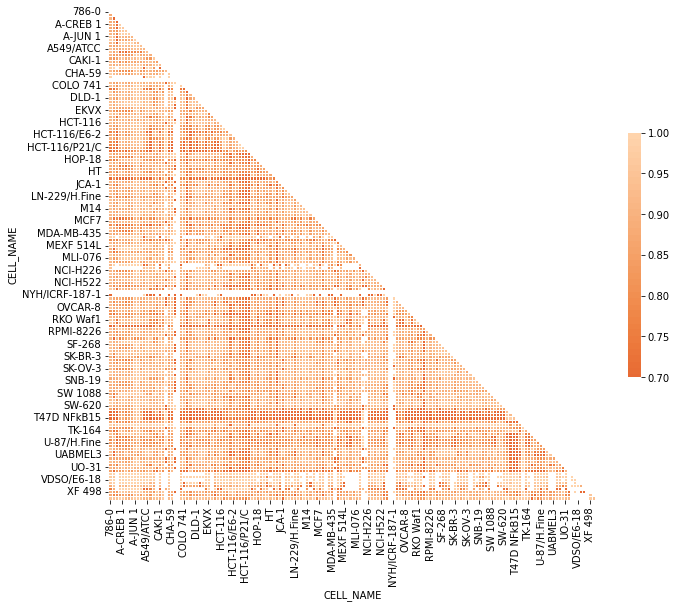

In [23]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrixCells, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatrixCells, mask=mask, vmax=1., vmin=0.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [9]:
import plotly.express as px

fig = px.imshow(corrMatrixCells)
fig.show()

In [16]:
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

pio.templates.default = "plotly_white"

go.Heatmap(
    z=corrMatrixCells,
    x=corrMatrixCells.columns,
    y=corrMatrixCells.columns,
    colorscale=px.colors.diverging.RdBu,
    zmin=-1,
    zmax=1
)

Heatmap({
    'colorscale': [[0.0, 'rgb(103,0,31)'], [0.1, 'rgb(178,24,43)'], [0.2,
                   'rgb(214,96,77)'], [0.3, 'rgb(244,165,130)'], [0.4,
                   'rgb(253,219,199)'], [0.5, 'rgb(247,247,247)'], [0.6,
                   'rgb(209,229,240)'], [0.7, 'rgb(146,197,222)'], [0.8,
                   'rgb(67,147,195)'], [0.9, 'rgb(33,102,172)'], [1.0,
                   'rgb(5,48,97)']],
    'x': array(['786-0', 'A-172/H.Fine', 'A-204', 'A-C/EBP 3', 'A-CREB 1', 'A-CREB 2',
                'A-FOS 2', 'A-FOS 3', 'A-JUN 1', 'A-JUN 3', 'A431', 'A498', 'A549/ATCC',
                'ACHN', 'BT-549', 'CACO-2', 'CAKI-1', 'CALU-1', 'CCD-19LU', 'CCRF-CEM',
                'CHA-59', 'CHO', 'CHO/159-1', 'COLO 205', 'COLO 741', 'COLO 746',
                'CXF 264L', 'DB', 'DLD-1', 'DMS 114', 'DMS 273', 'DU-145', 'EKVX',
                'ES-2 CNCR', 'H1299p53RE29', 'HCC-2998', 'HCT-116', 'HCT-116/CMV-1',
                'HCT-116/CMV-2', 'HCT-116/E6-1', 'HCT-116/E6-2', 'HCT-116/P',

In [14]:
import plotly.graph_objects as go
import plotly.figure_factory as ff

import numpy as np
from scipy.spatial.distance import pdist, squareform


# get data
# data = np.genfromtxt("http://files.figshare.com/2133304/ExpRawData_E_TABM_84_A_AFFY_44.tab",
#                      names=True,usecols=tuple(range(1,30)),dtype=float, delimiter="\t")
# data_array = data.view((np.float, len(data.dtype.names)))
data_array = np.array(correlation.transpose())
labels = np.array(correlation.columns)
# data_array = np.nan_to_num(data_array)
# Initialize figure by creating upper dendrogram
fig = ff.create_dendrogram(data_array, orientation='bottom', labels=labels)
for i in range(len(fig['data'])):
    fig['data'][i]['yaxis'] = 'y2'

# Create Side Dendrogram
dendro_side = ff.create_dendrogram(data_array, orientation='right')
for i in range(len(dendro_side['data'])):
    dendro_side['data'][i]['xaxis'] = 'x2'

# Add Side Dendrogram Data to Figure
for data in dendro_side['data']:
    fig.add_trace(data)

# Create Heatmap
dendro_leaves = dendro_side['layout']['yaxis']['ticktext']
dendro_leaves = list(map(int, dendro_leaves))
data_dist = pdist(data_array)
heat_data = squareform(data_dist)
heat_data = heat_data[dendro_leaves,:]
heat_data = heat_data[:,dendro_leaves]

heatmap = [
    go.Heatmap(
        x = dendro_leaves,
        y = dendro_leaves,
        z = heat_data,
        colorscale = 'Blues'
    )
]

heatmap[0]['x'] = fig['layout']['xaxis']['tickvals']
heatmap[0]['y'] = dendro_side['layout']['yaxis']['tickvals']

# Add Heatmap Data to Figure
for data in heatmap:
    fig.add_trace(data)

# Edit Layout
fig.update_layout({'width':800, 'height':800,
                         'showlegend':False, 'hovermode': 'closest',
                         })
# Edit xaxis
fig.update_layout(xaxis={'domain': [.15, 1],
                                  'mirror': False,
                                  'showgrid': False,
                                  'showline': False,
                                  'zeroline': False,
                                  'ticks':""})
# Edit xaxis2
fig.update_layout(xaxis2={'domain': [0, .15],
                                   'mirror': False,
                                   'showgrid': False,
                                   'showline': False,
                                   'zeroline': False,
                                   'showticklabels': False,
                                   'ticks':""})

# Edit yaxis
fig.update_layout(yaxis={'domain': [0, .85],
                                  'mirror': False,
                                  'showgrid': False,
                                  'showline': False,
                                  'zeroline': False,
                                  'showticklabels': False,
                                  'ticks': ""
                        })
# Edit yaxis2
fig.update_layout(yaxis2={'domain':[.825, .975],
                                   'mirror': False,
                                   'showgrid': False,
                                   'showline': False,
                                   'zeroline': False,
                                   'showticklabels': False,
                                   'ticks':""})

# Plot!
fig.show()

In [11]:
# import seaborn as sn
# import matplotlib.pyplot as plt

# corrMatrixNSC = correlation.transpose().corr()

In [12]:

# sn.heatmap(corrMatrixNSC, annot=True)
# plt.figure(figsize=(16, 16))
# plt.show()